<h1 align='center'> Computing the $m=1$ Wake Function for the Plasma Hollow Channel from PIC Data</h1>
<center>
Stephen D. Webb <br>
RadiaSoft, LLC <br>
swebb@radiasoft.net</center>

Developed for a project supported by the United States Department of Energy, Office of Science, Office of High Energy Physics under contract number DE-SC0018718.

***
## Introduction

Having established that FBPIC is able to model the $m=0$ wake in a hollow plasma channel for some length, it is now on us to compute the $m=1$ wake fields, which are the dipole modes we are concerned with for beam break-up instability in a plasma accelerator.

The concept here is that computing wake functions from simulation data is difficult because it is difficult to de-convolve the bunch distribution from the response to that distribution. We will therefore compute the impedances instead of the wake functions, i.e. if

>$ \psi (\zeta) = \int d \zeta' ~ W(\zeta - \zeta') \rho(\zeta')$

then the Fourier transform of the potential is defined by the impedance

>$ \tilde \psi(k) = Z(k) \tilde{\rho}(k)$

and we are able to easily calculate $\tilde{\rho}$ as input, and the trailing force from the fields generated in the simulation. We can then compute the impedance as the ratio of the Fourier transforms of those two.

This approach offers the additional benefit that it is easier to filter noise in the Fourier domain than in real space. In our particular implementation, we apply a $\tanh$-filter which will suppress any spectral features of the field on the order of one cell size, on the assumption that cell-scale fluctuations in the field are driven more by numerical noise than actual physics.

This is meant as a comparative benchmark for the hollow channel where, again, the exact analytic expressions are known.


***

In [2]:
## Imports

# standard python libraries
import numpy as np
from scipy import constants
from scipy.special import erfc, k0, k1, kn

import shutil, os

%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py as hdf5

# Imports for the simulations, and setting up the plots
from fbpic.main import Simulation
from fbpic.openpmd_diag import FieldDiagnostic, ParticleDiagnostic, \
     set_periodic_checkpoint, restart_from_checkpoint
from fbpic.lpa_utils.bunch import add_elec_bunch_gaussian

# set the colormap and centre the colorbar

import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

***
## Simulation Parameters

In this section, we develop a simulation of the hollow channel. The hollow channel refers to the fact that a drive and witness bunch travel through a hollow ring of plasma -- this set up is akin to having an extremely small beam pipe. For the FBPIC simulation, this requires creating a ring of quiescent electron plasma, and a drive and witness beam initiated with self-consistent fields. We will neglect the ion motion in the plasma channel for this simulation.

The simulation uses a moving window, beginning with the drive and witness bunch outside the hollow plasma channel, then passing through, with the simulation running until the fields reach an approximate steady state. We will then use those fields to compute the wake fields and impedances, and compare to the theoretical results in [ref. 1](#References).

The hollow plasma channel has a density $n_e$ and a radius $b$, and the local plasma frequency is given by $\omega_p = \sqrt{\frac{4 \pi n_e e^2}{m_e}}$ for the electron charge $e$ and mass $m_e$. The plasma wavenumber is $k_p = \omega_p / c$. Because PIC algorithms do not like hard edges in charge density, we will use a linear ramp on the density of the plasma hollow channel, with a slope $k_{ramp}$ specified below.

In [3]:
## Do we want to run a new simulation?

run_new_simulation = True
hc_directory = './hollow_channel'
sc_directory = './space_charge'

## Beam parameters

# Drive bunch is gaussian
drive_sigma_r = 4.5e-6  # meters
drive_sigma_z = 9.e-6  # meters
drive_Q = 1.e8*(-1.*constants.elementary_charge)   # Coulombs
drive_N_macro = 20000
drive_gamma = 1.e6

# Offset the bunch to test the m=1 wake
bunch_offset = 5.e-6 #meters

# turn the drive beam on and off, as required.
use_drive_bunch = True

## Plasma channel parameters

n_plasma = 1.e18        # cm^-3
channel_inner_radius = 20.e-6 # meters

# convert to per cubic meter
n_plasma *= 100**3

# derived plasma quantities
omega_p = np.sqrt(n_plasma*constants.elementary_charge**2/(constants.m_e*constants.epsilon_0))
k_p = omega_p/constants.c

lambda_p = 2.*np.pi/k_p

## Domain parameters

# Domain size, include the whole thing and some trailing distance
domain_length = 15.*drive_sigma_z  # meters
domain_radius = 2.*channel_inner_radius  # meters

# Grid size, resolve the drive bunch
Delta_z = np.minimum(0.05*drive_sigma_z, 0.05*lambda_p)  # meters
Delta_r = np.minimum(0.05*drive_sigma_r, 0.05*lambda_p)  # meters

# Derived quantities
Nz = int(np.rint(domain_length/Delta_z))
Nr = int(np.rint(domain_radius/Delta_r))

dt = (np.sqrt((Delta_z**2 + Delta_r**2)/2.)/constants.c) * .95  # sec, small fudge factor 
                                                                # to prevent particles from 
                                                                # covering a full cell per time step
        
# Moving window
window_v = constants.c

# start the ramp after the drive bunch has existed a while

ramp_start = domain_length
ramp_length = 5.*drive_sigma_z

channel_ramp_length = 10.*Delta_r

# We want to run the simulation just long enough for the fields to form behind the drive bunch, 
# so we will simulate for twenty bunch sigmas

sim_length = (ramp_start + ramp_length + 30.*drive_sigma_z)/constants.c

# Use only the primary azimuthal mode
Nm = 2

# Define the diagnostics
write_fields = True
write_particles = True

Nsteps = int(sim_length/dt)

dump_period = Nsteps - 1


# create the density function for the hollow channel
def dens_func( z, r ) :
    """Returns relative density at position z and r"""
    # Allocate relative density
    n = np.ones_like(z)
    # Make linear ramp
    n = np.where( z < ramp_start + ramp_length, (z-ramp_start)/ramp_length, n )
    # Supress density before the ramp
    n = np.where( z < ramp_start, 0., n )
    n = np.where( r < channel_inner_radius + channel_ramp_length, (r - channel_inner_radius)/channel_ramp_length, n)
    n = np.where( r < channel_inner_radius, 0., n)
    return(n)


***
## The Simulation

Here we run the actual simulation of the beams traveling through the hollow channel.

***

In [3]:

if run_new_simulation:
    # remove old data
    if os.path.exists(hc_directory + '/hdf5'):
        shutil.rmtree(hc_directory + '/hdf5')

    # Create the simulation
    sim = Simulation(Nz, domain_length, Nr, domain_radius, Nm, dt, boundaries='open')
    # micromanage the particle species
    sim.ptcl = []

    # add the gaussian drive bunch
    if use_drive_bunch:
        add_elec_bunch_gaussian( sim, 
                                sig_r = drive_sigma_r, 
                                sig_z = drive_sigma_z, 
                                n_emit=0., 
                                gamma0=drive_gamma, 
                                sig_gamma=1.,
                                Q=drive_Q, 
                                N=drive_N_macro, 
                                tf=0.0, 
                                zf=.75*domain_length, boost=None)
        
        if write_particles:
            sim.diags.append( ParticleChargeDensityDiagnostic( dump_period, sim, {'drive_bunch' : sim.ptcl[0]}) )


    sim.ptcl[-1].y[:] += bunch_offset

    # add the hollow channel electrons
    hollow_channel_electrons = sim.add_new_species(q = constants.elementary_charge,
                                     m = constants.electron_mass,
                                     dens_func = dens_func, 
                                     n = n_plasma, p_nz = 2, p_nr = 2, p_nt = 2)

    # Set the moving window
    sim.set_moving_window(v = window_v)

    # Add diagnostics
    if write_fields:
        sim.diags.append( FieldDiagnostic(dump_period, sim.fld, sim.comm, write_dir='./hollow_channel') )
    if write_particles:
        sim.diags.append( ParticleDiagnostic(dump_period,
                        {'electrons': sim.ptcl[0]}, sim.comm, write_dir='./hollow_channel' ) )

    # remove old data
    # run the simulation
    sim.step(Nsteps)


FBPIC (0.9.4)

Running on CPU (32 threads per process) 

Calculating initial space charge field...
Done.

|███████████████████████████████████| 1331/1331, 0:00:00 left, 262 ms/step[K
Total time taken (with compilation): 0:06:20
Average time per iteration (with compilation): 286 ms



In [4]:
# Plot the particle and field data

file = hdf5.File(hc_directory + '/hdf5/data00001330.h5','r')
data = file.get('data/')
step = data.get('1330')
ptcls = step.get('particles')
electrons = ptcls.get('electrons')
pos = electrons.get('position')

fields = step.get('fields')
rho = fields.get('rho')

# convert to number density
therho = np.abs(rho[0,:,:])/constants.elementary_charge
# convert to cm^-3
therho /= 100.**3

Es = fields.get('E')
Ez = Es.get('z')
Er = Es.get('r')
Et = Es.get('t')
theEz = Ez[0,:,:]
theEr = Er[2,:,:]
theEt = Et[2,:,:]

Bs = fields.get('B')
Bz = Bs.get('z')
Br = Bs.get('r')
Bt = Bs.get('t')
theBz = Bz[0,:,:]
theBr = Br[2,:,:]
theBt = Bt[2,:,:]

x = pos.get('x')
y = pos.get('y')
z = pos.get('z')

xPos = x[:]
yPos = y[:]
z = z[:]
r = np.sqrt(xPos**2 + yPos**2)

file.close()

In [5]:
if run_new_simulation:
    # We need to run a second simulation to get the space charge fields of the bunch, so we can subtract that out

    # remove old data
    if os.path.exists(sc_directory + '/hdf5'):
        shutil.rmtree(sc_directory + '/hdf5')

    # Create the simulation
    sim = Simulation(Nz, domain_length, Nr, domain_radius, Nm, dt, boundaries='open')
    # micromanage the particle species
    sim.ptcl = []

    # add the gaussian drive bunch
    if use_drive_bunch:
        add_elec_bunch_gaussian( sim, 
                                sig_r = drive_sigma_r, 
                                sig_z = drive_sigma_z, 
                                n_emit=0., 
                                gamma0=drive_gamma, 
                                sig_gamma=1.,
                                Q=drive_Q, 
                                N=drive_N_macro, 
                                tf=0.0, 
                                zf=.75*domain_length, boost=None)

    sim.ptcl[-1].y[:] += bunch_offset

    # Set the moving window
    sim.set_moving_window(v = window_v)

    # Add diagnostics
    if write_fields:
        sim.diags.append( FieldDiagnostic(dump_period, sim.fld, sim.comm, write_dir='./space_charge' ) )
    if write_particles:
        sim.diags.append( ParticleDiagnostic(dump_period,
                        {'electrons': sim.ptcl[0]}, sim.comm, write_dir='./space_charge' ) )

    # remove old data
    # run the simulation
    sim.step(Nsteps)


FBPIC (0.9.4)

Running on CPU (32 threads per process) 

Calculating initial space charge field...
Done.

|███████████████████████████████████| 1331/1331, 0:00:00 left, 258 ms/step
Total time taken (with compilation): 0:06:14
Average time per iteration (with compilation): 281 ms



In [6]:
# Plot the particle and field data

file = hdf5.File('./space_charge/hdf5/data00001330.h5','r')
data = file.get('data/')
step = data.get('1330')

fields = step.get('fields')

rho_bunch = fields.get('rho')

# convert to number density
therho_bunch = np.abs(rho_bunch[0,:,:])/constants.elementary_charge
# convert to cm^-3
therho_bunch /= 100.**3

Es = fields.get('E')
Ez_bunch = Es.get('z')
Er_bunch = Es.get('r')
Et_bunch = Es.get('t')

print np.shape(Er_bunch)

theEz_bunch = Ez_bunch[0,:,:]
theEr_bunch = Er_bunch[2,:,:]
theEt_bunch = Et_bunch[2,:,:]

Bs = fields.get('B')
Bz_bunch = Bs.get('z')
Br_bunch = Bs.get('r')
Bt_bunch = Bs.get('t')
theBz_bunch = Bz_bunch[0,:,:]
theBr_bunch = Br_bunch[2,:,:]
theBt_bunch = Bt_bunch[2,:,:]

file.close()

(3, 178, 300)


In [7]:
r = np.linspace(0., domain_radius, Nr)
zeta = np.linspace(0., domain_length, Nz)

# move zeta so zero is centered on the drive bunch
z_avg = np.average(z)
z_avg -= constants.c * dt*Nsteps

zeta -= z_avg

zz, rr = np.meshgrid(zeta, r)

<IPython.core.display.Javascript object>


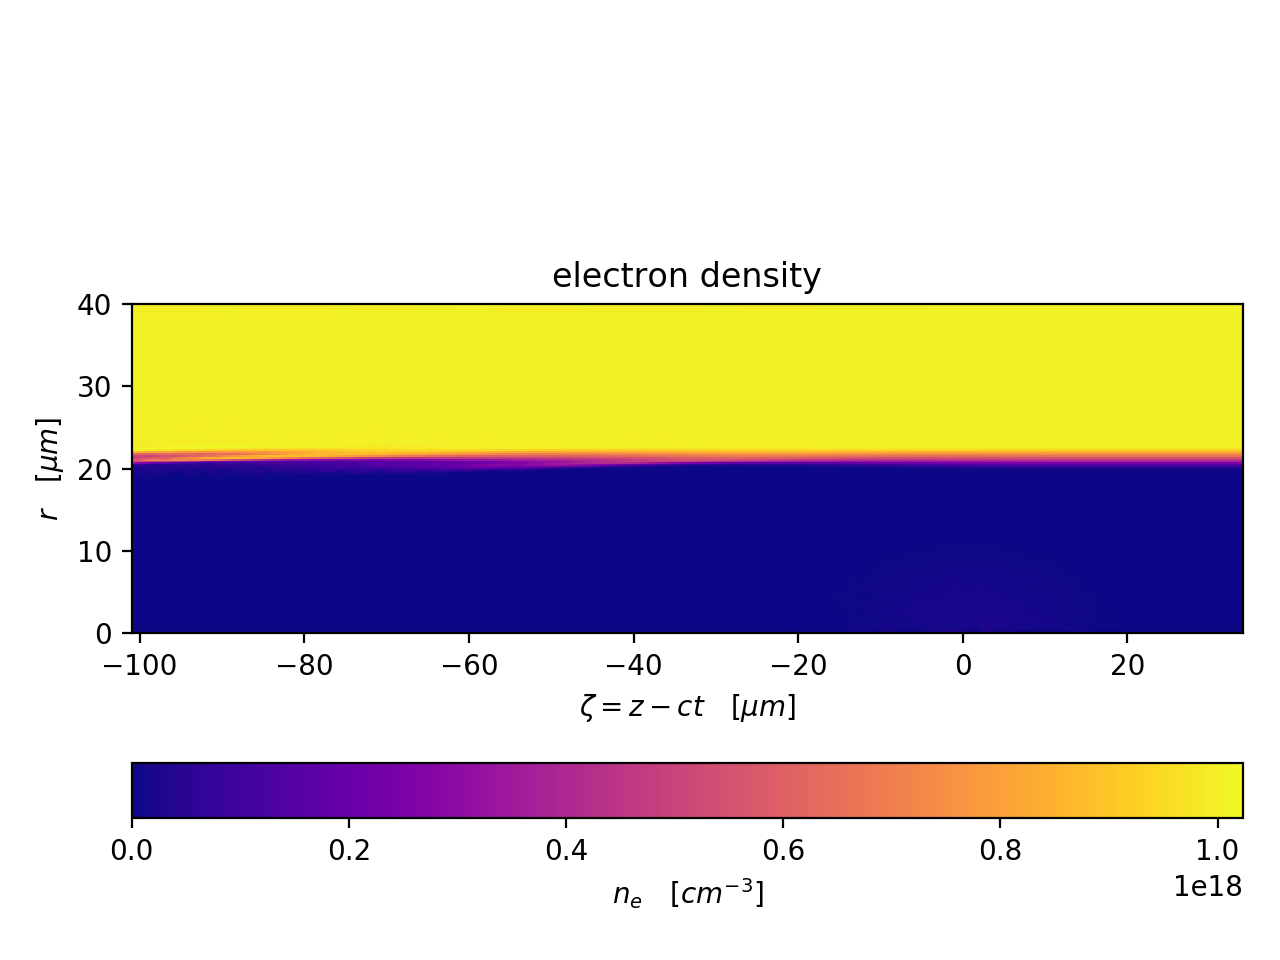

In [8]:
fig = plt.figure()

plt.imshow(therho,extent=[zeta[0]*1.e6,zeta[-1]*1.e6, r[0]*1.e6, r[-1]*1.e6], cmap='plasma', origin='lower')
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$n_e \quad [cm^{-3}]$')
plt.title('electron density')
plt.tight_layout()

plt.savefig('rho.png')

<IPython.core.display.Javascript object>


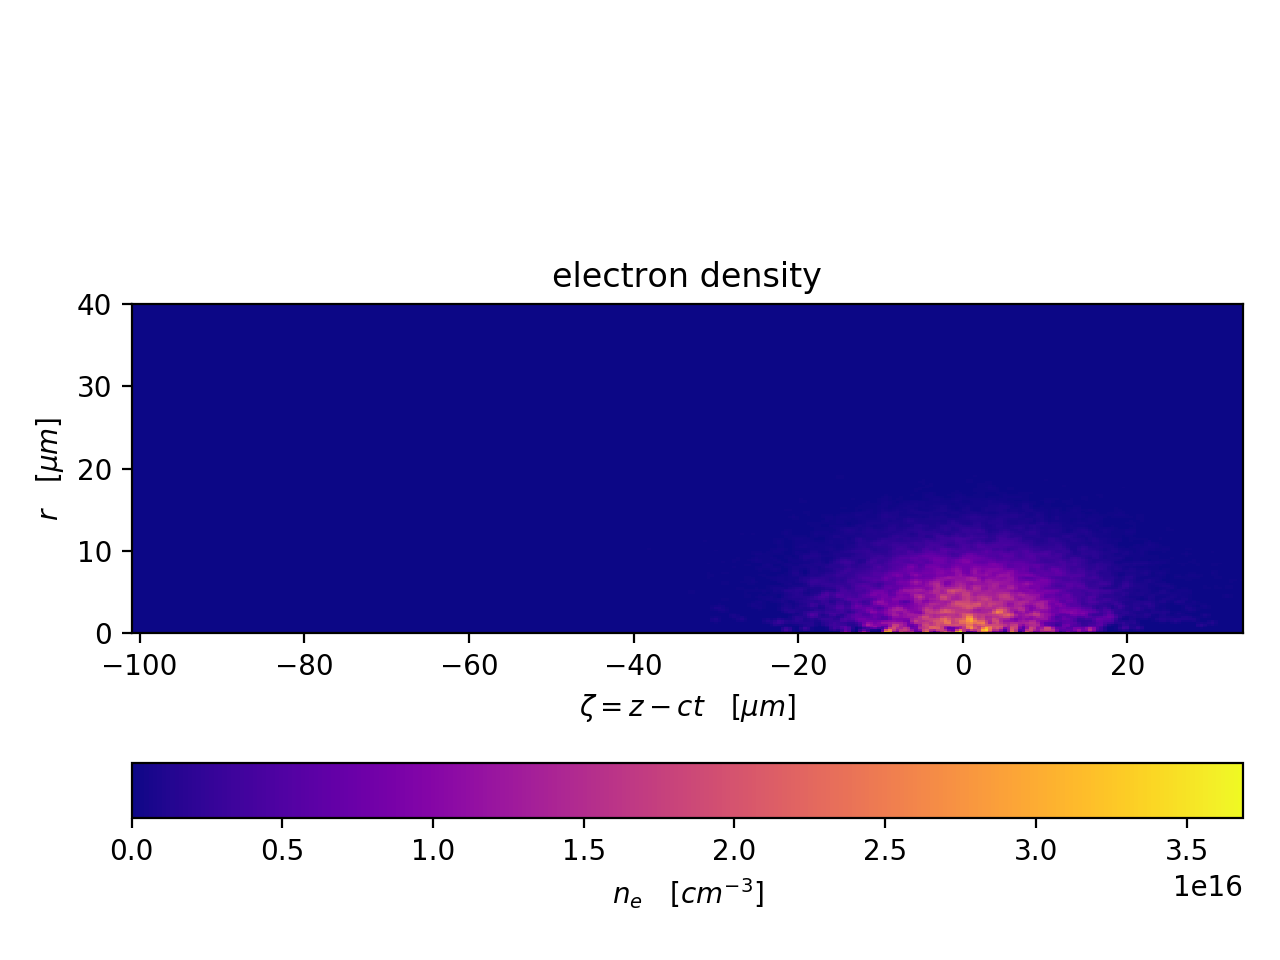

In [9]:
fig = plt.figure()

plt.imshow(therho_bunch,extent=[zeta[0]*1.e6,zeta[-1]*1.e6, r[0]*1.e6, r[-1]*1.e6], cmap='plasma', origin='lower')
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$n_e \quad [cm^{-3}]$')
plt.title('electron density')
plt.tight_layout()

plt.savefig('rho.png')

<IPython.core.display.Javascript object>


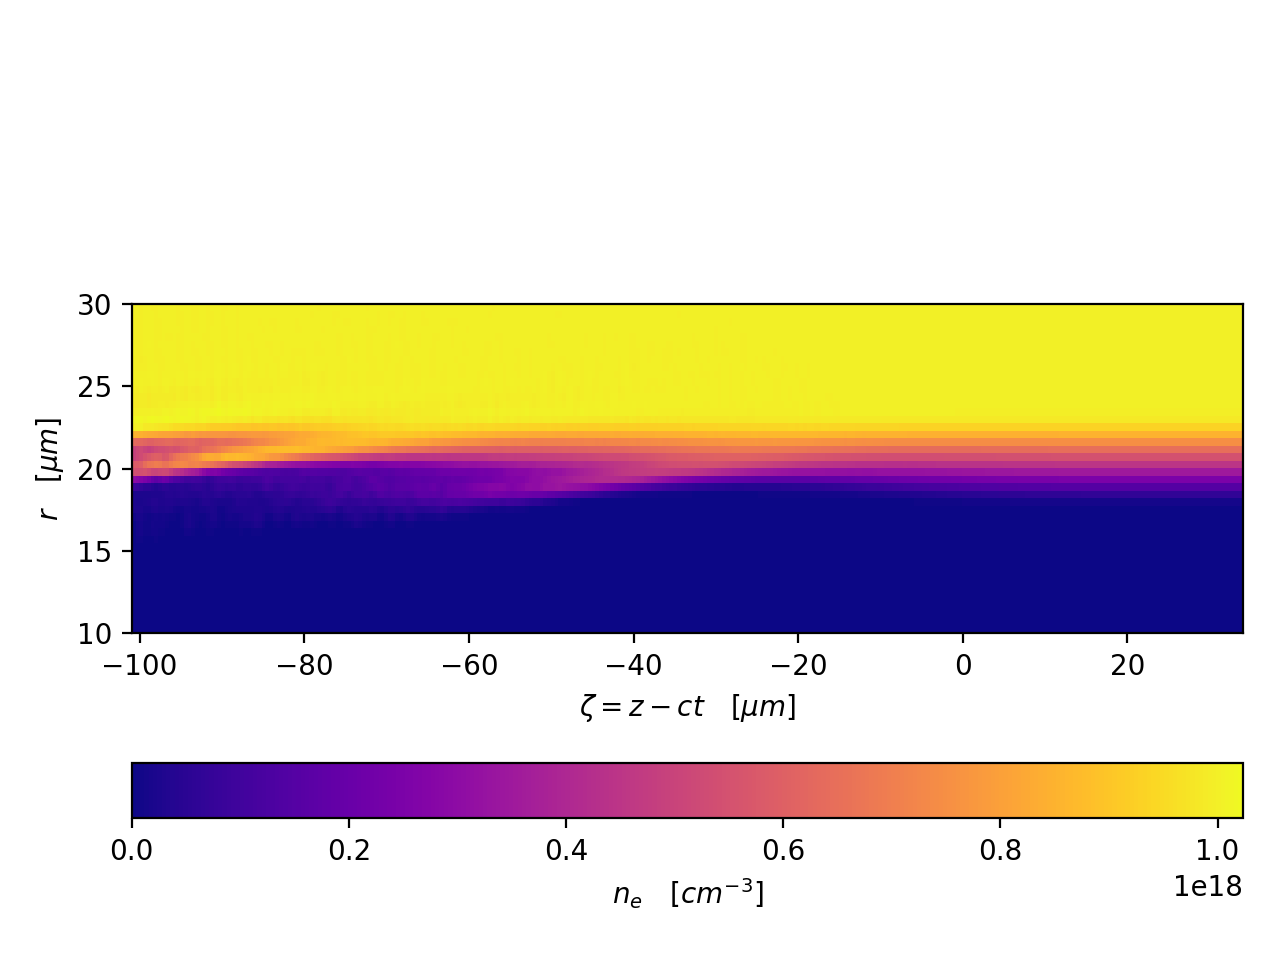

In [10]:
shape = np.shape(therho)
zoomed_min = int(shape[0]*.4)
zoomed_max = int(shape[0]*.65)
zoomedrho = therho[zoomed_min:zoomed_max,:]

fig = plt.figure()

plt.imshow(zoomedrho,extent=[zeta[0]*1.e6,zeta[-1]*1.e6, r[-1]*1.e6*.25, r[-1]*1.e6*.75], cmap='plasma', origin='lower',aspect=2)
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$n_e \quad [cm^{-3}]$')

plt.tight_layout()

plt.savefig('zoomedrho.png')


<IPython.core.display.Javascript object>


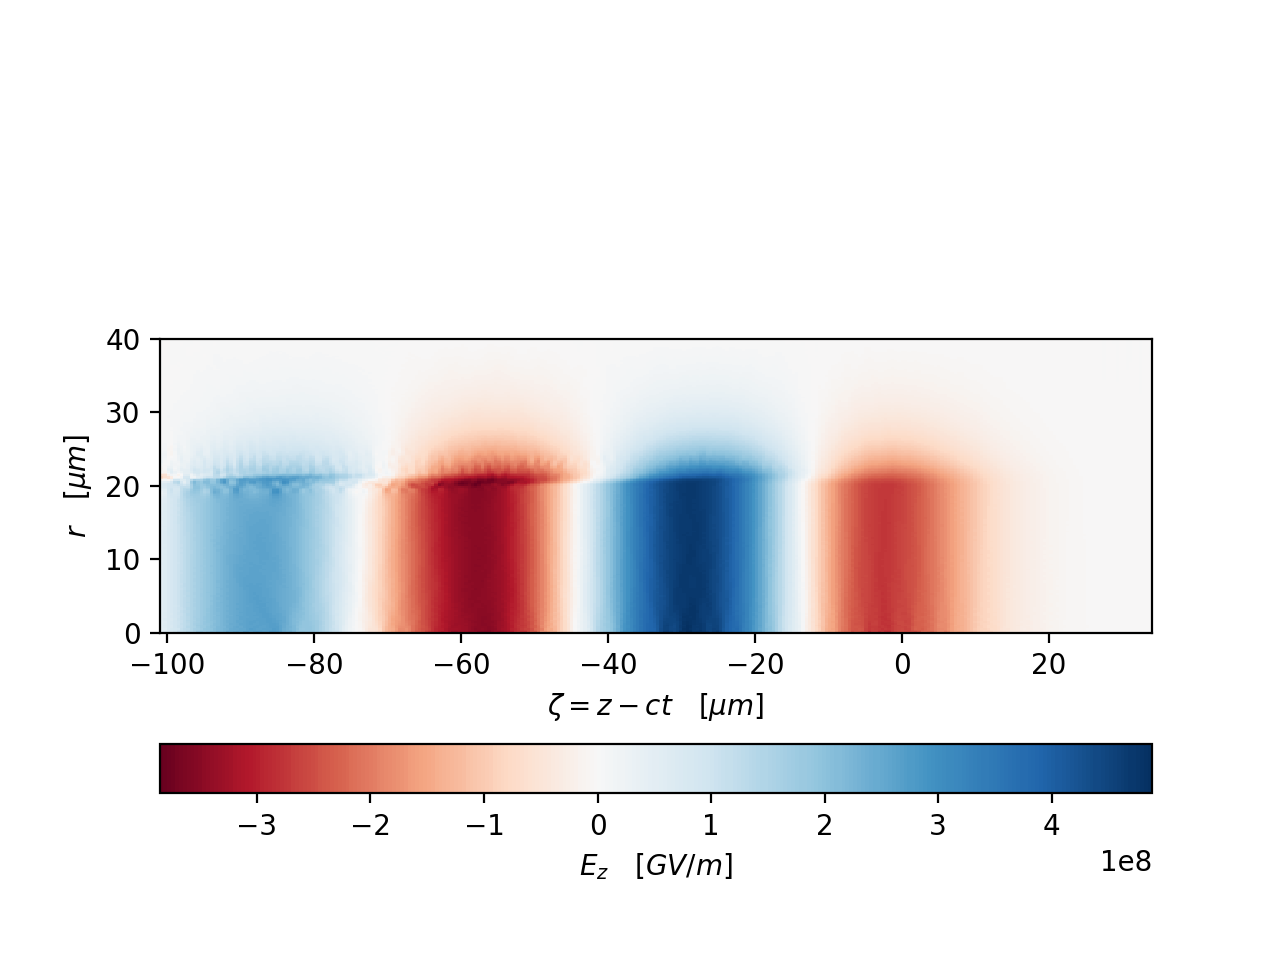

In [11]:
fig = plt.figure()

# Fix the midpoint to zero field

ezmax = np.amax(theEz)
ezmin = np.amin(theEz)
ezavg = 0.

plt.imshow(theEz,extent=[zeta[0]*1.e6, zeta[-1]*1.e6, r[0]*1.e6, r[-1]*1.e6], 
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=ezavg,vmin=ezmin, vmax=ezmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_z \quad [GV/m]$')

plt.savefig('Ez.png')


<IPython.core.display.Javascript object>


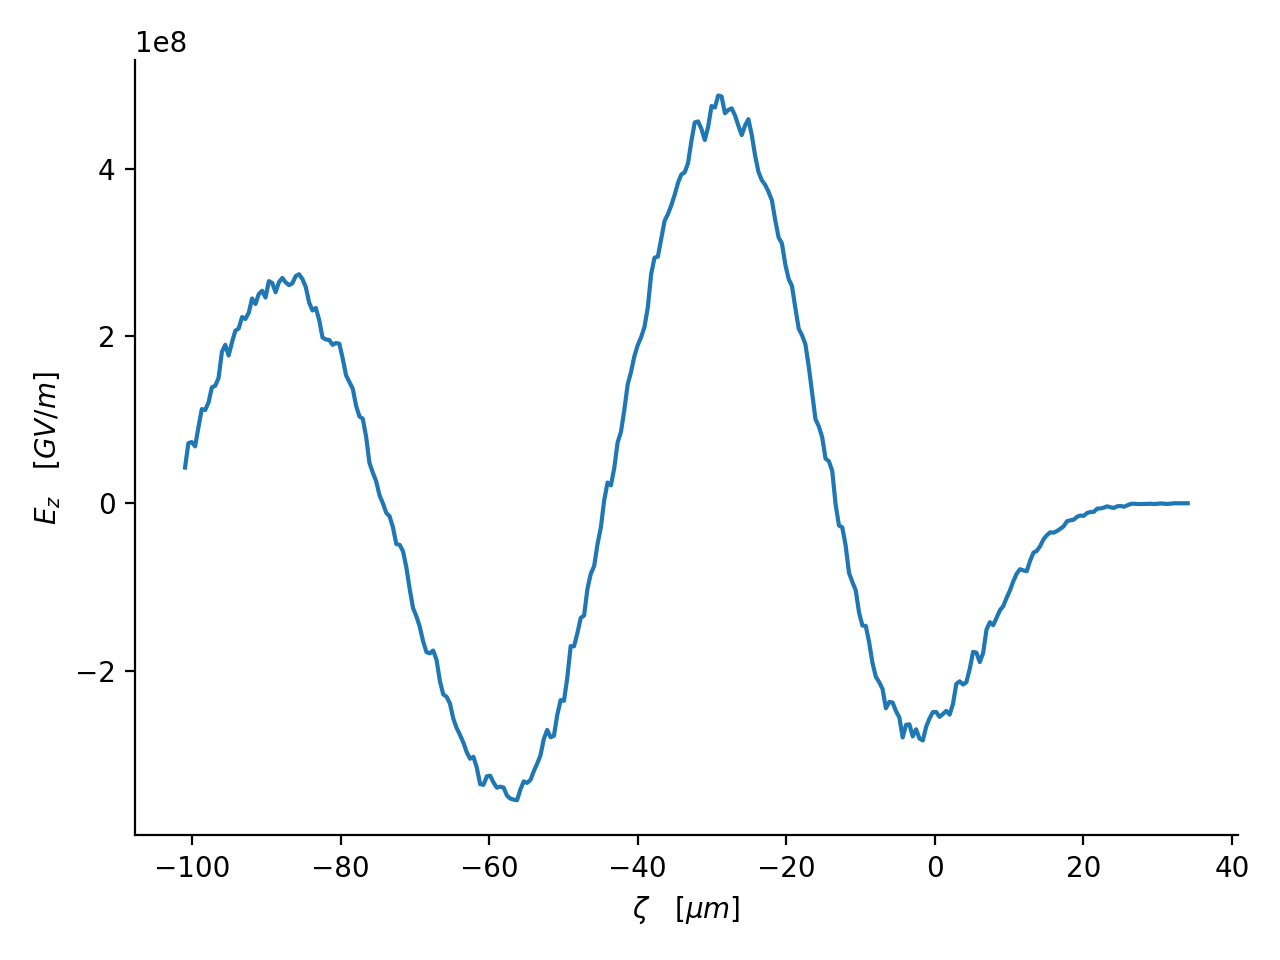

In [12]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

plt.plot(zeta*1.e6, theEz[0,:])
plt.xlabel(r'$\zeta \quad [\mu m]$')
plt.ylabel(r'$E_z \quad [GV/m]$')
plt.tight_layout()

<IPython.core.display.Javascript object>


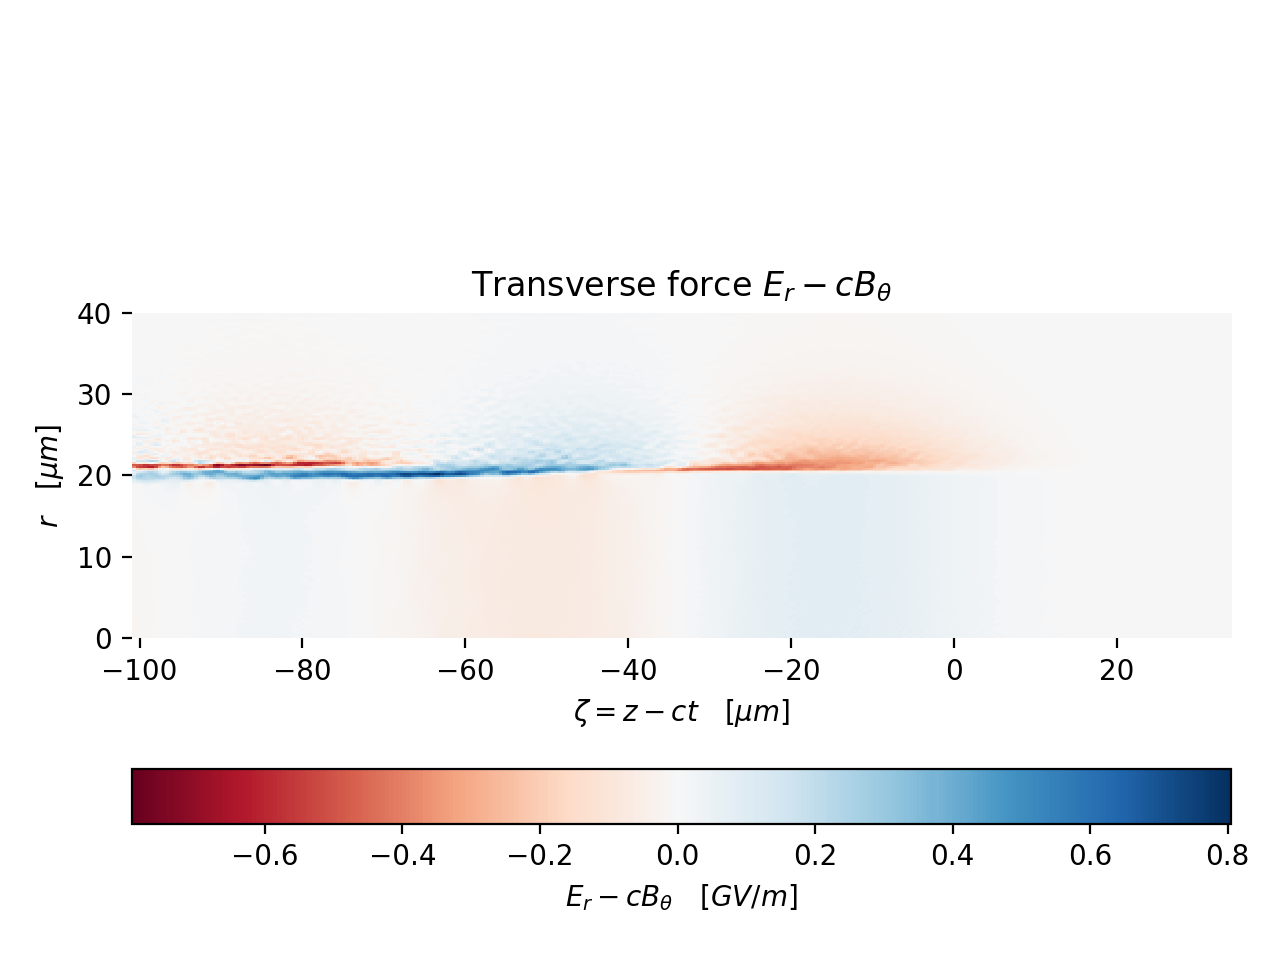

In [13]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
Fr = (theEr - constants.speed_of_light*(theBt))*1.e-9

frmax = np.amax(Fr)
frmin = np.amin(Fr)
fravg = 0.

plt.imshow(Fr,extent=[zeta[0]*1.e6, zeta[-1]*1.e6, r[0]*1.e6, r[-1]*1.e6], 
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_r - c B_\theta \quad [GV/m]$')
plt.title(r'Transverse force $E_r - c B_\theta$')
plt.tight_layout()

plt.savefig('transverse_force.png')

<IPython.core.display.Javascript object>


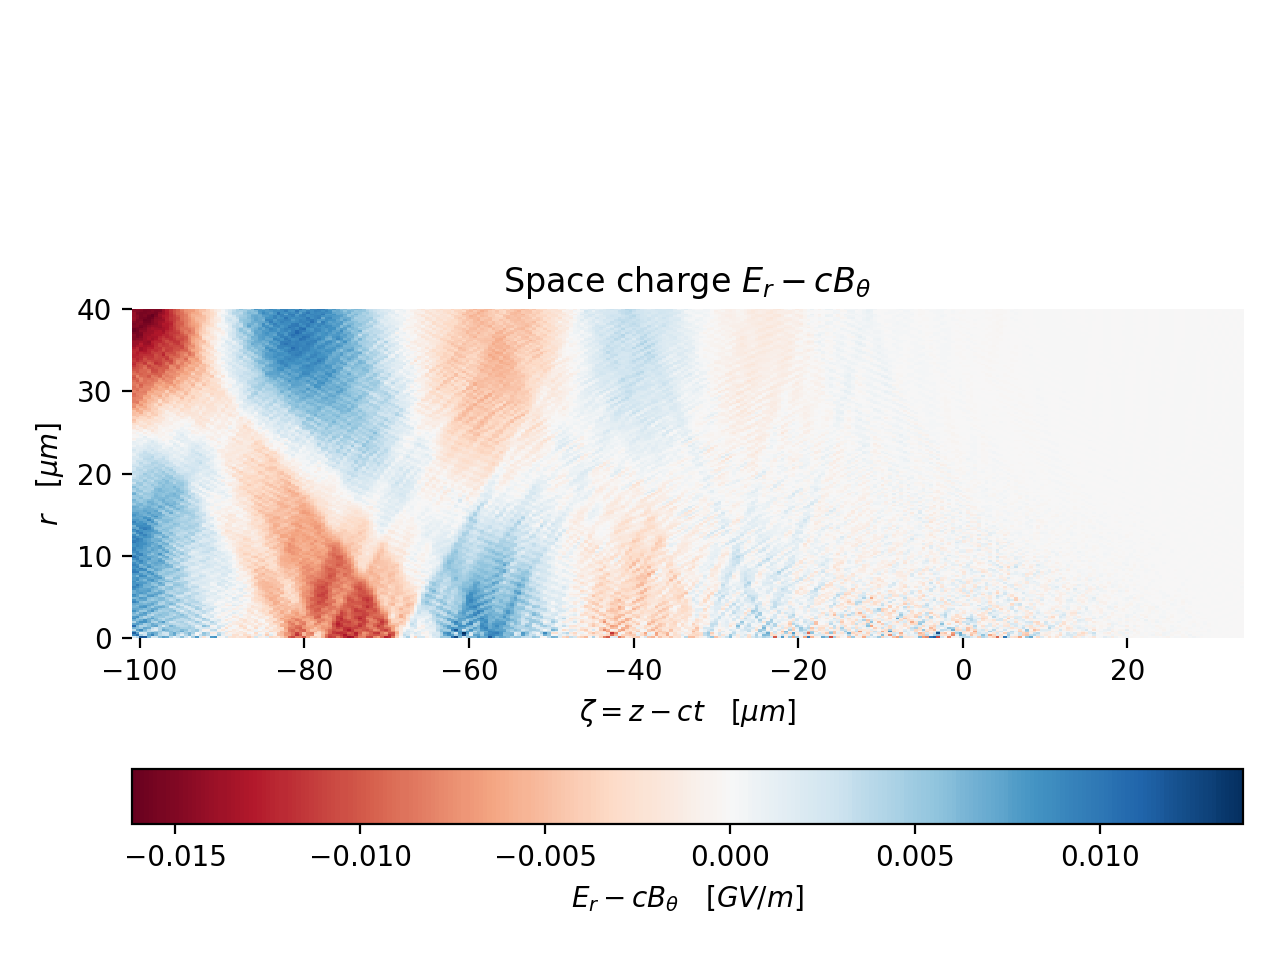

In [40]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

Fr_sc = (theEr_bunch - constants.speed_of_light*(theBt_bunch))*1.e-9

frmax = np.amax(Fr_sc)
frmin = np.amin(Fr_sc)
fravg = 0.

plt.imshow(Fr_sc,extent=[zeta[0]*1.e6, zeta[-1]*1.e6, r[0]*1.e6, r[-1]*1.e6], 
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_r - c B_\theta \quad [GV/m]$')
plt.title(r'Space charge $E_r - c B_\theta$')
plt.tight_layout()

plt.savefig('Fr_sc.png')

<IPython.core.display.Javascript object>


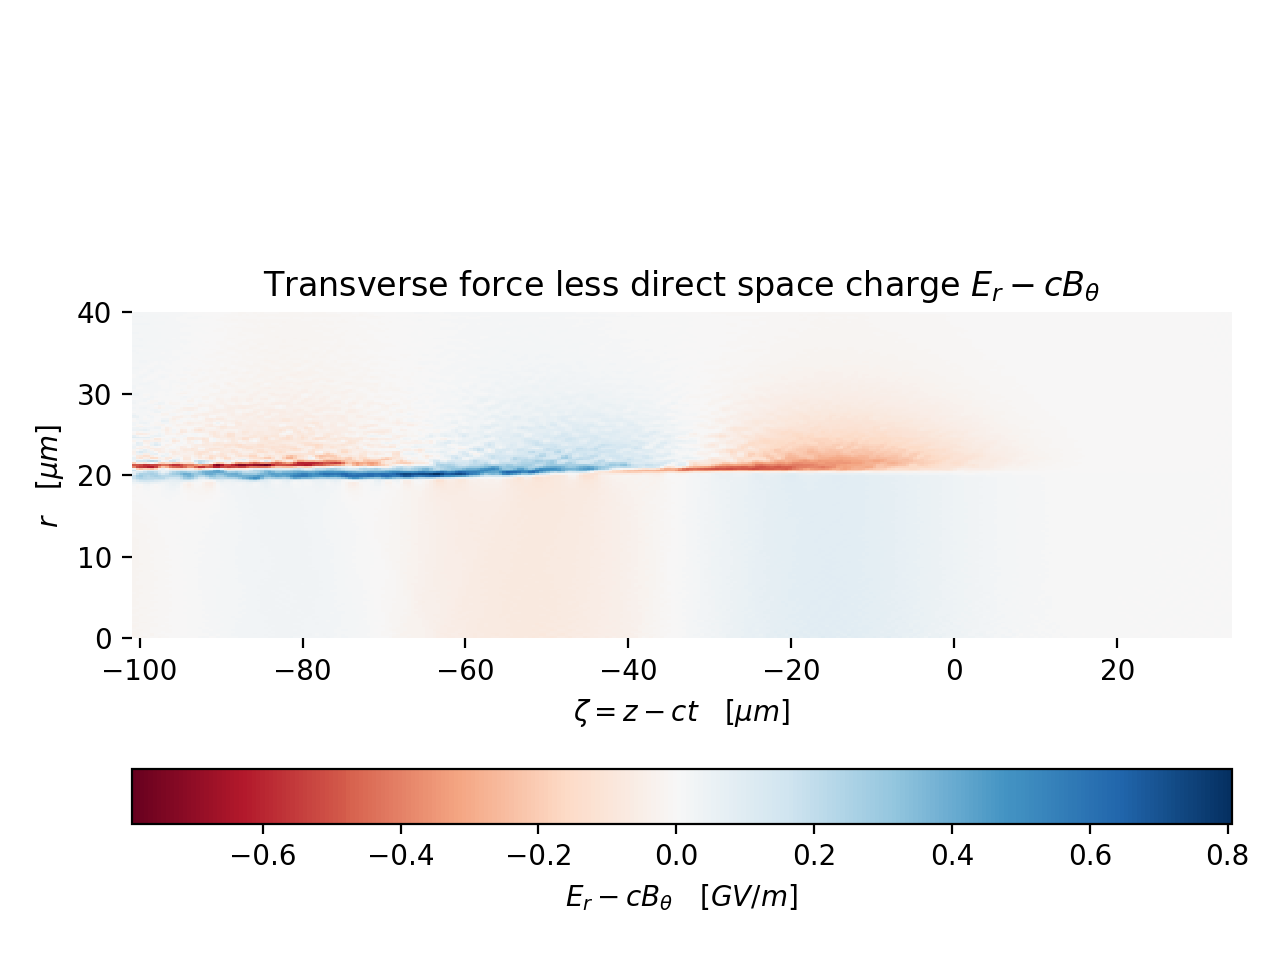

In [15]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

Fr_lessc = Fr - Fr_sc

frmax = np.amax(Fr_lessc)
frmin = np.amin(Fr_lessc)
fravg = 0.

plt.imshow(Fr_lessc,extent=[zeta[0]*1.e6, zeta[-1]*1.e6, r[0]*1.e6, r[-1]*1.e6], 
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_r - c B_\theta \quad [GV/m]$')
plt.title(r'Transverse force less direct space charge $E_r - c B_\theta$')
plt.tight_layout()

plt.savefig('Fr_less_sc.png')

***
## Comparing the analytic and computed wake fields

Using the field data generated from the simulation above, we can compute the $m=0$ wake, which corresponds to the accelerating potential generated by the drive and witness bunches. Per the taxonomy used in Chao [ref. 4](#References), and the corresponding modes computed in [ref. 1](#References), we expect the wake functions to be given by

>$
W_{\parallel}^{(m)} = \frac{2 \kappa_m}{b^{2m}} \cos \left ( \Omega_m k_p \zeta \right ) \\
W_{\perp}^{(m)} = \frac{2 m \kappa_m}{b^{2m} \Omega_m k_p} \sin \left (\Omega_m k_p \zeta \right )
$

where

>$ \kappa_m = \frac{\omega_p^2}{c^2} \left [ \frac{K_m(k_p b)}{k_p b K_{m+1}(k_p b)} \right ] \left [ 1 + \frac{k_p b K_m(k_p b)}{2 (m+1) K_{m+1}(k_p b)} \right ]^{-1} $

and

>$ \Omega_m = \left [ \frac{(1 + \delta_{m,0}) (m+1) K_{m+1}(k_p b)}{2 (m+1) K_{m+1}(k_p b) + k_p b K_m(k_p b)} \right ]^{1/2}$

Here $K_m$ is the $m^{th}$ order modified Bessel function of the second kind. For the $m=0$ wake, this means that, for an on-axis beam, we expect to see no transverse forces and a longitudinal force that varies sinusoidally and scales with the channel radius. More specifically, we expect that the longitudinal electric field will be given by

>$ E_z(\zeta) = \int_\zeta^{\infty} d\zeta' ~W_{\parallel}^{(0)}(\zeta - \zeta') \rho(\zeta')$

and for there to be no $\vec{E}_\perp$ or $\vec{B}$ excited by the drive bunch. For our gaussian charge distribution, 

>$\rho = \frac{Q_{beam}}{\sqrt{2 \pi \sigma_z^2}} \exp [- \zeta^2/2 \sigma_z^2]$,

this means that

>$ E_z(\zeta) = \kappa_0 Q_{beam}   e^{-(\Omega_0 k_p \sigma_z)^2/2}~ \mathfrak{Re} \left ( e^{-i \Omega_0 k_p  \zeta} \textrm{Erfc} \left ( \frac{\zeta - i \Omega_0 k_p  \sigma_z^2}{\sqrt{2 }\sigma_z} \right ) + \textrm{c.c.} \right )$

This should only work for short distances, as the linear response treatment of the plasma channel will break down once the electrons sweep back into the hollow channel, as demonstrated by Lindstrom et al. [ref. 5](#References). Therefore, our benchmark will only be for short distances behind the drive bunch.

***

In [16]:
def compute_analytic_Ez(Omega0kp, sigma, Q, kappa0, zeta):
        
    phase_arg = Omega0kp * zeta
    erfc_arg  = (zeta - 1.j*Omega0kp*sigma*sigma)/(np.sqrt(2)*sigma)
        
    Ez = np.exp(-1.j*phase_arg)*(erfc(erfc_arg))
    Ez = np.real(Ez)
    Ez *= kappa0 * Q * np.exp(- 0.5 * (Omega0kp * sigma)**2)/(4*np.pi*constants.epsilon_0)
    
    return Ez

In [35]:
def compute_analytic_W1_perp(Omega1kp, sigma, Q, kappa1, zeta):
    
    phase_arg = Omega1kp * zeta
    erfc_arg  = (zeta - 1.j*Omega1kp*sigma*sigma)/(np.sqrt(2)*sigma)
        
    W1 = np.exp(-1.j*phase_arg)*(erfc(erfc_arg))
        
    W1 = np.imag(W1)
    W1 *= kappa1 * Q * np.exp(- 0.5 * (Omega1kp * sigma)**2)/(4*np.pi*constants.epsilon_0) #/Omega1kp
        
    return W1
    

In [36]:
# Test compute_analytic_Ez with the parameters for the plasma channel above
kpb = k_p*channel_inner_radius
Omega0 = np.sqrt( 2.*k1(kpb) / ( 2*k1(kpb) + kpb*k0(kpb) ) )
Omega1 = np.sqrt( 2.*kn(2, kpb) / ( 4*kn(2, kpb) + kpb*k1(kpb) ) )
kappa0 = k_p*k_p*( k0(kpb)/(kpb*k1(kpb)) ) / ( 1. + kpb*k0(kpb) / (2.*k1(kpb)) )
kappa1 = k_p*k_p*( k1(kpb)/(kpb*kn(2, kpb)) ) / ( 1. + kpb*k1(kpb) / (4.*kn(2, kpb)) )

sigma = drive_sigma_z
Omega0kp = Omega0*k_p
Omega1kp = Omega1*k_p
Q = drive_Q

thePhase = Omega0kp*zeta

W1 = compute_analytic_W1_perp(Omega1kp, sigma, Q, kappa1, zeta)

Fr = (theEr-theEr_bunch - constants.speed_of_light*(theBt - theBt_bunch))*1.e-9


<IPython.core.display.Javascript object>


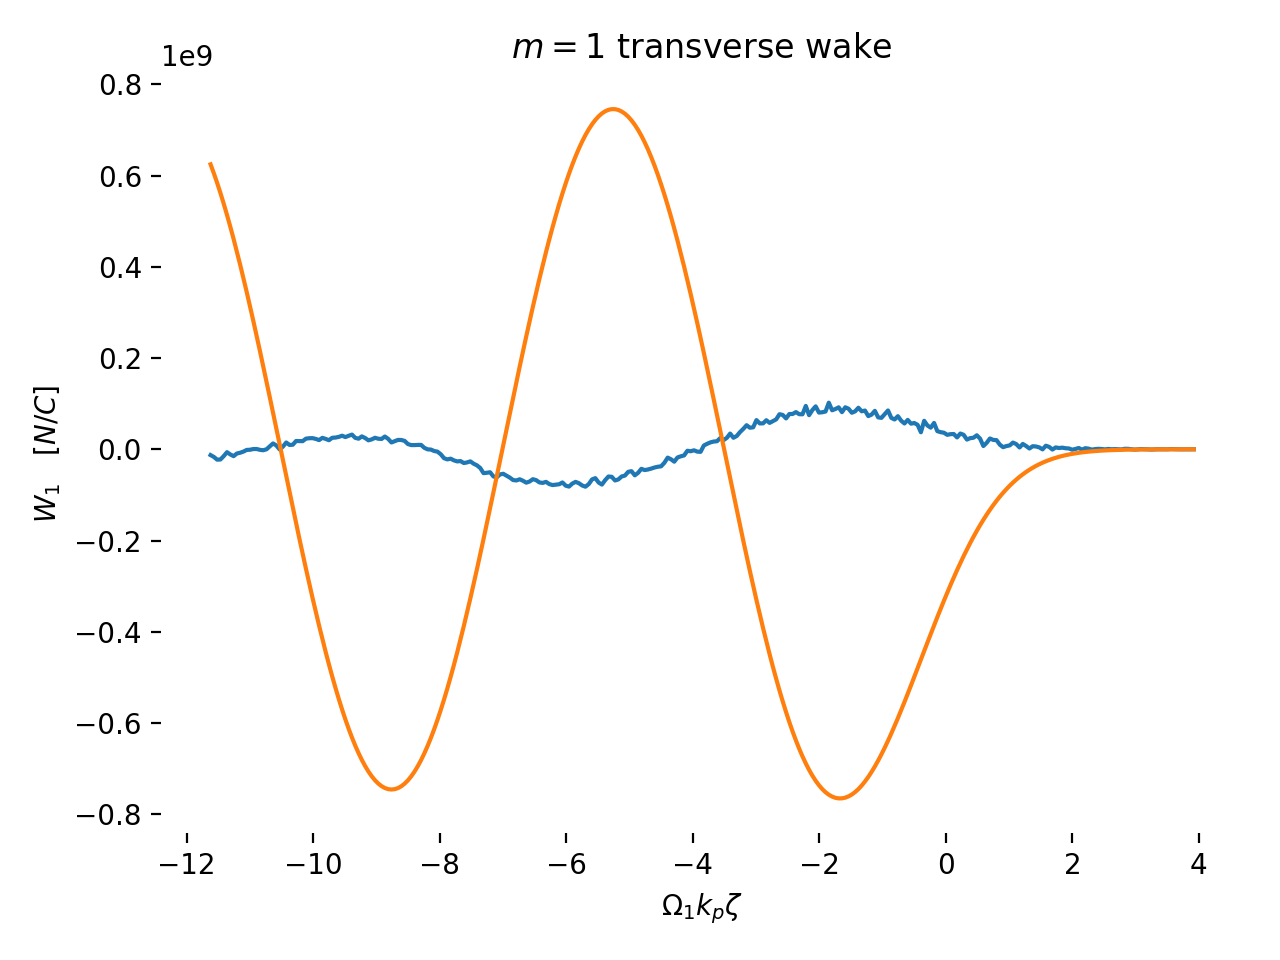

<IPython.core.display.Javascript object>


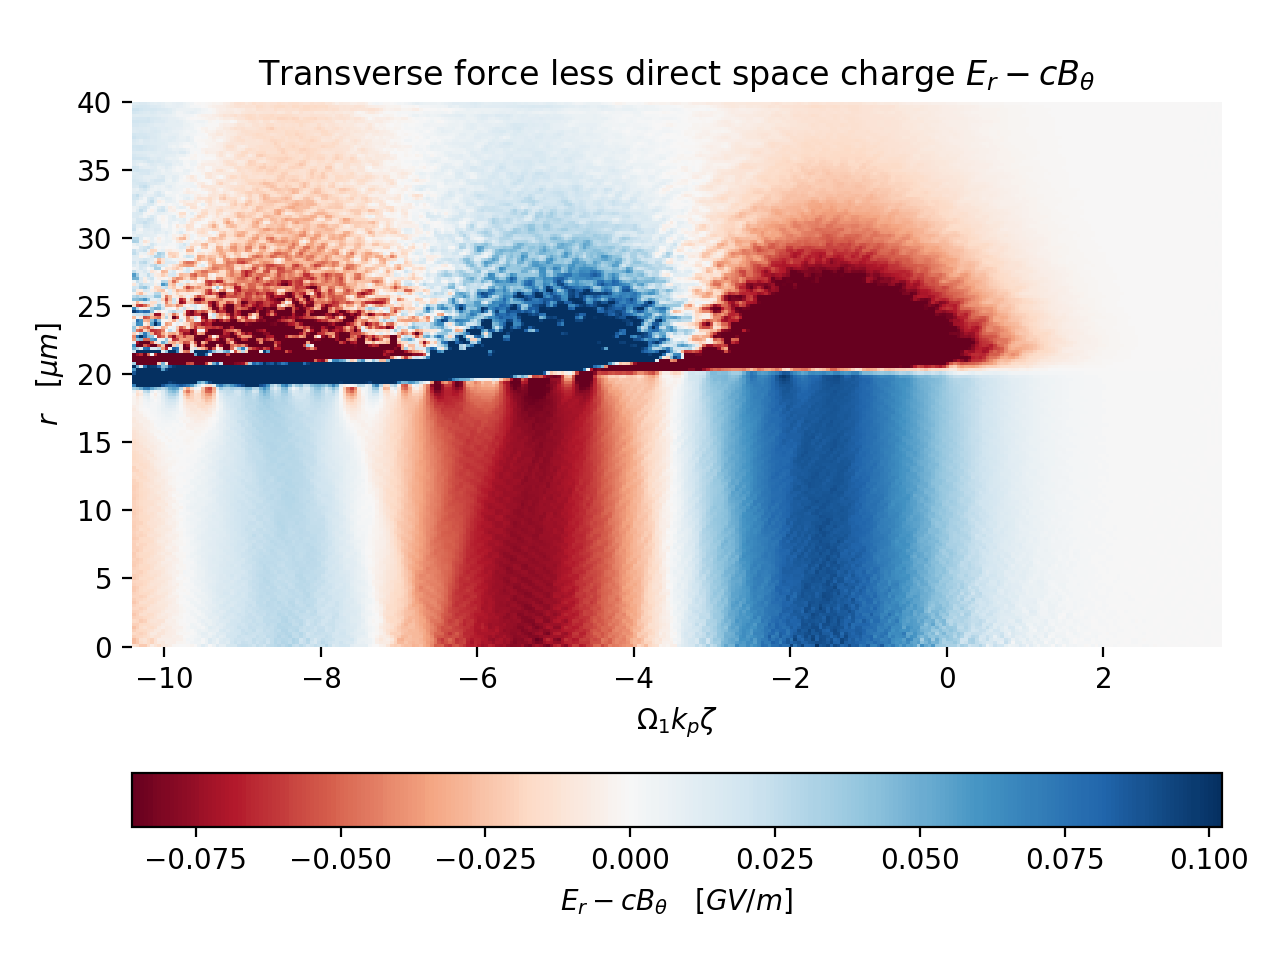

In [39]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

plt.plot(thePhase, Fr_lessc[0,:]*1.e9)
plt.plot(thePhase, W1)
plt.xlabel(r'$\Omega_1 k_p \zeta$')
plt.ylabel(r'$W_1 \quad [N/C]$')
plt.title(r'$m = 1$ transverse wake')
plt.tight_layout()

plt.savefig('m1_wake.png')

fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 



frmax = np.amax(Fr_lessc[0:75,:])
frmin = np.amin(Fr_lessc[0:75,:])
fravg = 0.

aspect_ratio = 0.5*(Omega1kp*zeta[-1] - Omega1kp*zeta[0])/ (r[-1]*1.e6)

plt.imshow(Fr_lessc,extent=[Omega1kp*zeta[0], Omega1kp*zeta[-1], r[0]*1.e6, r[-1]*1.e6], 
           cmap='RdBu', origin='lower', 
           norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax),
          aspect = aspect_ratio)
plt.xlabel(r'$\Omega_1 k_p \zeta$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_r - c B_\theta \quad [GV/m]$')
plt.title(r'Transverse force less direct space charge $E_r - c B_\theta$')

plt.tight_layout()

plt.savefig('Fr.png')

<IPython.core.display.Javascript object>


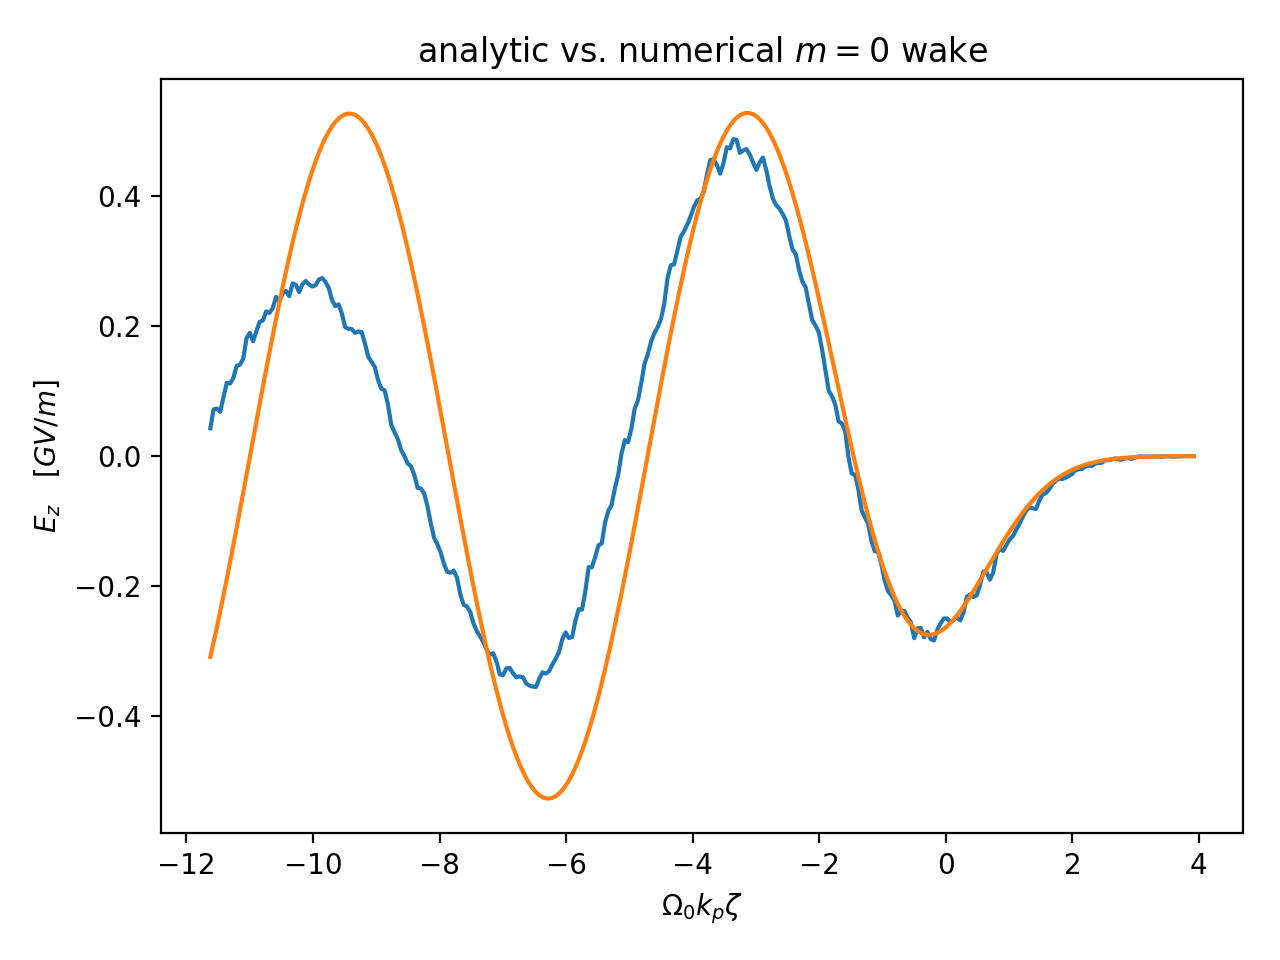

In [20]:
fig = plt.figure()

my_Ez = compute_analytic_Ez(Omega0kp, sigma, Q, kappa0, zeta)

plt.plot(Omega0kp * zeta, theEz[0,:]*1.e-9)
plt.plot(Omega0kp * zeta, my_Ez*1.e-9)
plt.xlabel(r'$\Omega_0 k_p \zeta$')
plt.ylabel(r'$E_z \quad [GV/m]$')
plt.title(r'analytic vs. numerical $m=0$ wake')
plt.tight_layout()

plt.savefig('analytic_vs_fbpic.png')

***
## References

> 1. C. B. Schroeder, D. H. Whittum, and J. S. Wurtele, "Multimode Analysis of the Hollow Plasma Channel Wakefield Accelerator", _Phys. Rev. Lett._ __82__, 1177 (1999). [https://doi.org/10.1103/PhysRevLett.82.1177](https://doi.org/10.1103/PhysRevLett.82.1177)

> 2. R. Lehe, M. Kirchen, I. A. Andriyash, B. B. Godfrey, and J.-L. Vay, "A spectral, quasi-cylindrical and dispersion-free Particle-In-Cell algorithm", _Comp. Phys. Comm._ __203__, pp. 66-82 (2016). [https://doi.org/10.1016/j.cpc.2016.02.007](https://doi.org/10.1016/j.cpc.2016.02.007)

> 3. C. Joshi _et al._ "Plasma wakefield acceleration experiments at FACET II", _Plasma Phys. Control. Fusion_ __60__, 3 (2018).

> 4. A. W. Chao, "Physics of Collective Beam Instabilities in High Energy Accelerators", John Wiley & Sons (1993)

> 5. C. A. Lindstrom _et al._ "Measurement of Transverse Wakefields Induced by a Misaligned Positron Bunch in a Hollow Channel Plasma Accelerator", _Phys. Rev. Lett._ __120__, 124802 (2018).